### Imports

In [1]:
import preprocessing
import pandas as pd
import evaluation as evaluation
from sklearn.model_selection import train_test_split
import nltk
import model
from matplotlib import pyplot as plt
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
nltk.download('punkt')
import pandas as pd
import zipfile
import os
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import load_model


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\marle\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Load Trainingdata

In [2]:
path = "data\spam1-train.zip"
input, labels,_ = preprocessing.load_data(path)
df = pd.DataFrame({'raw': input, 'label': labels})
df["preprocessed"] = df["raw"].copy()
df["preprocessed"] = df["preprocessed"].apply(preprocessing.clean_data)
df.head()

,raw,label,preprocessed
0,"Subject: nb real vallum , x . anax , l . evitr...",1,nb real vallum x anax l evitra soma m...
1,Subject: special investor update .\r\non janua...,1,special investor update on january lst 2002...
2,Subject: younger and healthier with ultimate -...,1,younger and healthier with ultimate hghl 728...
3,Subject: new employee\r\ni am pleased to annou...,0,new employee i am pleased to announce that s...
4,Subject: fw : fserh hi roselution dvd movies\r...,1,fw fserh hi roselution dvd movies hello y...


### Split dataset

In [3]:
train_X, test_X, train_Y, test_Y = train_test_split(df['preprocessed'],
                                                    df['label'],
                                                    test_size = 0.2,
                                                    random_state = 42)

### Prepare data for neural network

In [4]:
max_len = 200 
train_sequences, test_sequences, tokenizer = model.prepare_sequences(train_X, test_X,max_len)

In [108]:
es = EarlyStopping(patience=6,
                   monitor = 'val_accuracy',
                   restore_best_weights = True)
 
lr = ReduceLROnPlateau(patience = 6,
                       monitor = 'val_loss',
                       factor = 0.5,
                       verbose = 0)

In [111]:
# Define parameters
input_dim = len(tokenizer.word_index) + 1  # Vocabulary size
embedding_dim = 100  
lstm_units = 128  
dense_units = 64  
max_len = 200  
dropout_rate = 0.2  

# Build the model
spam_model = model.build_lstm_model(name="Spam_Model", 
                          input_dim=input_dim, 
                          embedding_dim=embedding_dim, 
                          lstm_units=lstm_units, 
                          dense_units=dense_units, 
                          max_len=max_len, 
                          dropout_rate=dropout_rate)

Model: "Spam_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_layer (Embedding)     │ (None, 200, 100)       │    11,745,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_layer (LSTM)               │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer (Dense)             │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer (Dropout)         │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,870,569 (45.28 MB)

 Trainable params: 11,870,569 (45.28 MB)

 Non-trainable params: 0 (0.00 B)

In [112]:

# Train the model
history = spam_model.fit(train_sequences, train_Y,
                    validation_split=0.2,
                    epochs=20, 
                    batch_size=64,
                    callbacks = [lr, es]
                   )

Epoch 1/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 68s 377ms/step - accuracy: 0.5875 - loss: 0.6525 - val_accuracy: 0.6950 - val_loss: 0.5620 - learning_rate: 0.0010
Epoch 2/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 66s 397ms/step - accuracy: 0.7375 - loss: 0.5192 - val_accuracy: 0.8890 - val_loss: 0.3184 - learning_rate: 0.0010
Epoch 3/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 66s 393ms/step - accuracy: 0.8813 - loss: 0.3228 - val_accuracy: 0.9317 - val_loss: 0.2236 - learning_rate: 0.0010
Epoch 4/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 68s 404ms/step - accuracy: 0.9416 - loss: 0.1901 - val_accuracy: 0.9842 - val_loss: 0.0638 - learning_rate: 0.0010
Epoch 5/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 62s 373ms/step - accuracy: 0.9793 - loss: 0.0855 - val_accuracy: 0.9880 - val_loss: 0.0441 - learning_rate: 0.0010
Epoch 6/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 61s 366ms/step - accuracy: 0.9903 - loss: 0.0447 - val_accuracy: 0.9884 - val_loss: 0.0495 - learning_rate: 0.0010
Epoch 7/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 58s 345ms/step - accuracy: 0.9

### Evaluate the model

In [113]:
test_loss, test_accuracy = spam_model.evaluate(test_sequences, test_Y)
print('Test Loss :',test_loss)
print('Test Accuracy :',test_accuracy)

105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - accuracy: 0.9882 - loss: 0.0546
Test Loss : 0.05096309259533882
Test Accuracy : 0.9876987934112549


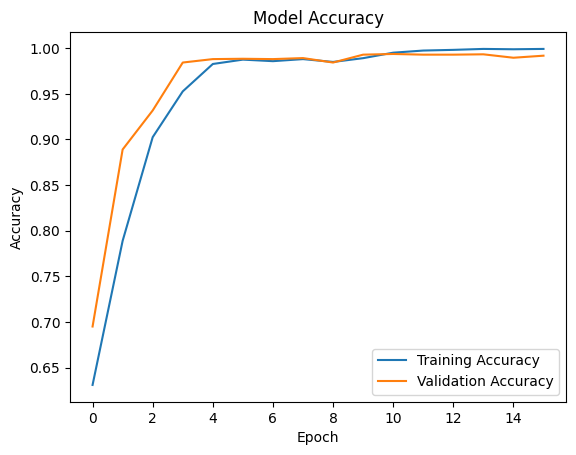

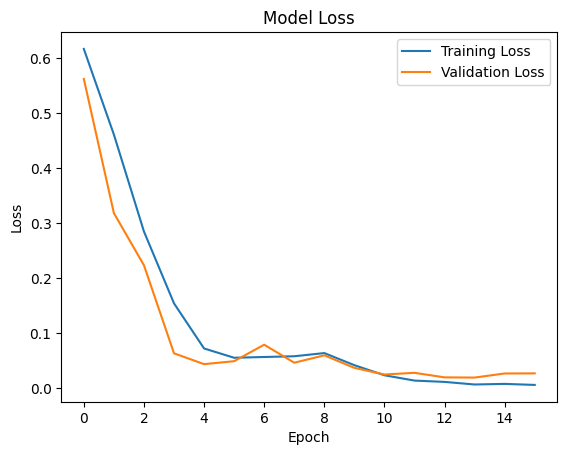

(None, None)

In [114]:
evaluation.plot_model_accuracy(history), evaluation.plot_model_loss(history)

### Test Model

In [116]:
prediction = spam_model.predict(test_sequences)
prediction = [1 if p > 0.5 else 0 for p in prediction]

105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 73ms/step


In [117]:
#compare the prediction with the actual label
result = pd.DataFrame({'input': test_X, 'label': test_Y, 'prediction': prediction})
result

,input,label,prediction
47,paliourg fw my wife made me buy this enlarg...,1,1
5804,sometimes not always i like the idea of a c...,1,1
7530,earn huge profits starting today mc ncxb ueyt...,1,1
2099,are you in the mood xghtmtggc viagra xenica...,1,1
16253,request notice htmlbody sorry for taking so...,1,1
...,...,...,...
9621,equistar just sold some same day today ga...,0,0
11600,help needed be burdened no more hello w...,1,1
2548,re unify thanks for the update i also want...,0,0
11384,finessing numbers 75 off for all new sof...,1,1


105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step
Accuracy: 0.9876987698769877
Precision: 0.9848668280871671
Recall: 0.9902617163724894
F1 Score: 0.9875569044006071
Balanced Accuracy: 0.9877344084821027


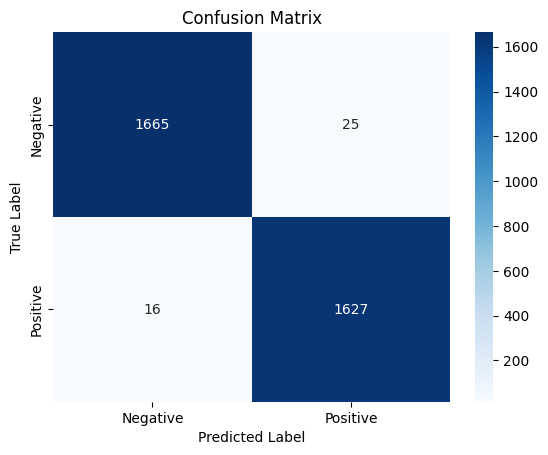


Classification Report:

              precision    recall  f1-score   support

    Negative       0.99      0.99      0.99      1690
    Positive       0.98      0.99      0.99      1643

    accuracy                           0.99      3333
   macro avg       0.99      0.99      0.99      3333
weighted avg       0.99      0.99      0.99      3333



In [118]:
evaluation.evaluate_model_performance(spam_model,test_sequences,test_Y)

In [119]:
#save the model
spam_model.save('spam_filter/model_1.keras')

### Analyze Errors

In [120]:
false_predictions = result[result['label'] != result['prediction']]
false_predictions.head()

,input,label,prediction
9640,great article mpgs will put you in jail r ...,1,0
3852,thanks for letting me know daughter artillery...,1,0
4280,entex increase rom huntsville woodlands c...,0,1
6348,re invitation for review a paper for the iee...,1,0
12446,real estate accountant hey guys can you hel...,0,1


C:\Users\marle\AppData\Local\Temp\ipykernel_6396\3339270336.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_predictions['text_length'] = false_predictions['input'].apply(len)


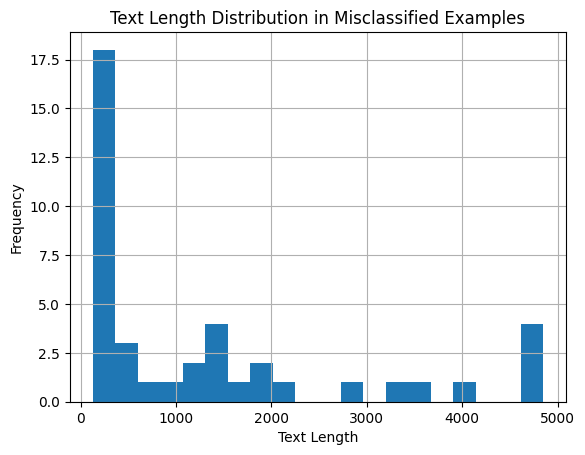

In [121]:


false_predictions['text_length'] = false_predictions['input'].apply(len)
false_predictions['text_length'].hist(bins=20)
plt.title('Text Length Distribution in Misclassified Examples')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

In [7]:
import importlib
importlib.reload(preprocessing)

<module 'preprocessing' from 'c:\\Users\\marle\\OneDrive\\TU Berlin\\2. Semester\\Smart Security Lab\\Unit_1_Spam_Filtering\\Task_1\\preprocessing.py'>

In [5]:
#load model
spam_model = load_model('spam_filter/model_1.keras')

In [14]:
# Load the data
path = "data/spam1-test.zip"
input, filenames = preprocessing.load_test_data(path)
df = pd.DataFrame({'raw': input, 'output': filenames})
df["preprocessed"] = df["raw"].copy()
df["preprocessed"] = df["preprocessed"].apply(preprocessing.clean_data)


In [15]:

sequences = tokenizer.texts_to_sequences(df["preprocessed"])
input_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')
predictions = spam_model.predict(input_sequences)
predictions = [1 if p > 0.5 else 0 for p in predictions]


df

471/471 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step


,raw,output,preprocessed
0,Subject: books about thailand\r\nhello\r\nplan...,data/spam1-test/vuzprzfggkwyrrpd.x,books about thailand hello planning a trip ...
1,"Subject: an interview\r\nshirley ,\r\nplease s...",data/spam1-test/cyepacmlgppblghl.x,an interview shirley please schedule an in...
2,Subject: energy futures contracts project\r\nh...,data/spam1-test/jojkaiztwzuisryw.x,energy futures contracts project hi vince an...
3,Subject: cowtrap allocation - 4 / 01\r\ni rece...,data/spam1-test/qwvwzlvblxpsxvsj.x,cowtrap allocation 4 01 i received the abo...
4,Subject: we have your home depot gift card wai...,data/spam1-test/epjykmkxgsdztlpt.x,we have your home depot gift card waiting c...
...,...,...,...
15046,Subject: start date : 1 / 26 / 02 ; hourahead ...,data/spam1-test/fqukrpxmiwelnmeu.x,start date 1 26 02 hourahead hour 11 s...
15047,Subject: revised agenda for management committ...,data/spam1-test/ivhcbrejybqaaqzb.x,revised agenda for management committee offsi...
15048,"Subject: re : henwood - ny\r\n$ 17 , 000 , inc...",data/spam1-test/bypgmwcwmtcrfyrx.x,re henwood ny 17 000 includes most majo...
15049,Subject: the national forum on corporate finan...,data/spam1-test/kbixvzexurfcalrw.x,the national forum on corporate finance mr ...


In [16]:
df['prediction'] = predictions
df['output'] = df['output'].astype(str) + ';' + df['prediction'].astype(str)
df

,raw,output,preprocessed,prediction
0,Subject: books about thailand\r\nhello\r\nplan...,data/spam1-test/vuzprzfggkwyrrpd.x;1,books about thailand hello planning a trip ...,1
1,"Subject: an interview\r\nshirley ,\r\nplease s...",data/spam1-test/cyepacmlgppblghl.x;0,an interview shirley please schedule an in...,0
2,Subject: energy futures contracts project\r\nh...,data/spam1-test/jojkaiztwzuisryw.x;0,energy futures contracts project hi vince an...,0
3,Subject: cowtrap allocation - 4 / 01\r\ni rece...,data/spam1-test/qwvwzlvblxpsxvsj.x;0,cowtrap allocation 4 01 i received the abo...,0
4,Subject: we have your home depot gift card wai...,data/spam1-test/epjykmkxgsdztlpt.x;1,we have your home depot gift card waiting c...,1
...,...,...,...,...
15046,Subject: start date : 1 / 26 / 02 ; hourahead ...,data/spam1-test/fqukrpxmiwelnmeu.x;0,start date 1 26 02 hourahead hour 11 s...,0
15047,Subject: revised agenda for management committ...,data/spam1-test/ivhcbrejybqaaqzb.x;0,revised agenda for management committee offsi...,0
15048,"Subject: re : henwood - ny\r\n$ 17 , 000 , inc...",data/spam1-test/bypgmwcwmtcrfyrx.x;0,re henwood ny 17 000 includes most majo...,0
15049,Subject: the national forum on corporate finan...,data/spam1-test/kbixvzexurfcalrw.x;0,the national forum on corporate finance mr ...,0


### Create CSV from output

In [19]:
df["output"].to_csv('results/output.csv', index=False, header=False)